In [1]:
# Notebook で自作ライブラリを import すると、読み込んだ時点のものが固定されてしまうが、
# 下記のコマンドを実行すると、後からライブラリの内容を変更しても再度読み込みをすれば反映される
%reload_ext autoreload
%autoreload 2

In [24]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import glob
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import Pool
from catboost import CatBoostClassifier
from tabpfn import TabPFNClassifier

from imblearn.over_sampling import RandomOverSampler,ADASYN
from imblearn.under_sampling import RandomUnderSampler,EditedNearestNeighbours
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import InstanceHardnessThreshold

import optuna

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import torch

In [18]:
import src.preprocess as pre
import src.classifire_optuna as co

# Processing settings

In [4]:
Category_processing = "onehot"
#None:カテゴリを処理しない
#label:ラベルエンコーディング
#onehot:ワンホットエンコーディング
TURNING = False
VALID = False
SUBMIT = True

# Path

In [54]:
cwd = os.getcwd()
cwd

'C:\\Users\\ctiha\\Desktop\\git upload'

In [55]:
ROOT = os.getcwd()
RAW = os.path.join(ROOT, "data/")
INPUT = os.path.join(ROOT, "data/input/")
OUTPUT = os.path.join(ROOT, "data/output/")
MODEL = os.path.join(ROOT, "model/output/")
SUBMISSION = os.path.join(ROOT, "submission")


# Config

In [56]:
CFG = {
        "Target":"MIS_Status",
        }
drop_list =['RetainedJob', 'GrAppv', 'DisbursementYear', 'SBA_Portion', 'Term', 'FranchiseCode_label', 'FranchiseCode_count', 'MonthlyRepayment', 'State_label', 'DisbursementGrossSBARatio_log', 'DisbursementGrossRatio_log', 'sub_GD', 'SubRetained', 'ScheduledPaidoff']


# Load Data

In [57]:
train = pd.read_csv(os.path.join(RAW, "train.csv"),index_col = "Unnamed: 0")
train_valid = pd.read_csv(os.path.join(RAW, "train_valid.csv"))
test = pd.read_csv(os.path.join(RAW, "test.csv"),index_col = "Unnamed: 0")
submit_sample = pd.read_csv(os.path.join(RAW, "sample_submission.csv"),header = None)



In [58]:
if VALID:
    train = train_valid[train_valid["valid"] == 0].drop(["valid"],axis=1)
    test = train_valid[train_valid["valid"] == 1].reset_index(drop=True).drop(["valid"],axis=1)

# Data Shaping


|ヘッダ名称|値例|データ型|説明|
|-|-|-|-|
|City|BILLINGS|str|借り手の会社の所在地（市）|
|State|FL|str|借り手の会社の所在地（州）|
|BankState|IL|str|貸し手の所在地（州）|
|Sector(*)|0|int|産業分類コード(詳細は後述)|
|Term|120|int|融資の期間（月）|
|NoEmp|2|int|融資を受ける前の事業の従業員数|
|NewExist|1|float|新規ビジネスかどうか.*1 = 既存のビジネス、2 = 新規ビジネス|
|CreateJob|1|int|企業が融資資金を使用して創出すると予想される雇用の数|
|RetainedJob|0|int|融資を受けたことで企業が維持すると予想される雇用の数|
|FranchiseCode|21|int|どのブランドのフランチャイズであるかを識別する一意の5桁のコード:*0または1は非フランチャイズを意味する|
|UrbanRural|1|int|*1 = 都市部、2 = 田舎、0 = 未定義|
|RevLineCr|N|str|リボルビング信用枠か:*Y = はい、N = いいえ|
|LowDoc|N|str|15 万ドル未満のローンを 1 ページの短い申請で処理できるプログラムか:*Y = はい、N = いいえ|
|DisbursementDate|12-Jan-05|str|融資の支払日|
|DisbursementGross|\$80,000.00|str|銀行によって支払われた金額|
|GrAppv|\$108,000.00|str|銀行によって承認されたローンの総額|
|SBA_Appv|\$102,000.00|str|SBAが保証する承認されたローンの金額|
|ApprovalDate|30-Sep-94|str|米国中小企業庁の承認日|
|ApprovalFY|1994|int|承認された財務年度|
|MIS_Status|1|int|ローンの状態(目的変数):*0 = 債務不履行、1 = 完済|

In [59]:
def Sector2label(train, test):
    for i,sec in enumerate([[11],[21],[22],[23],[31,32,33],[42],[44,45],[48,49],[51],[52],[53],[54],[55],[56],[61],[62],[71],[72],[81],[92]]):
        train["Sector"] = train["Sector"].map(lambda x:i if x in sec else x)
        test["Sector"] = test["Sector"].map(lambda x:i if x in sec else x)
    return train, test
def edit_Sector(train, test):
    train, test = Sector2label(train, test)
    
    enc = sp.OneHotEncoder( sparse=False )
    enc.fit(train[["Sector"]])
    
    cate = list(enc.categories_[0].astype("str"))
    cate = ["Sector_" + item for item in cate]
    tmp = pd.DataFrame(enc.transform(train[["Sector"]]),columns = cate)
    train = pd.concat([train, tmp],axis=1)
    
    tmp = pd.DataFrame(enc.transform(test[["Sector"]]),columns = cate)
    tmp.index = test.index
    test = pd.concat([test, tmp],axis=1)
    
    train = train.drop(["Sector"],axis=1)
    test = test.drop(["Sector"],axis=1)
    
    return train, test

def edit_state(train, test):
    enc = sp.OneHotEncoder( sparse=False )
    enc.fit(train[["State"]])
    
    tmp = pd.DataFrame(enc.transform(train[["State"]]),columns = enc.categories_[0])
    train = pd.concat([train, tmp],axis=1)
    
    tmp = pd.DataFrame(enc.transform(test[["State"]]),columns = enc.categories_[0])
    tmp.index = test.index
    test = pd.concat([test, tmp],axis=1)
    
    train = train.drop(["State"],axis=1)
    test = test.drop(["State"],axis=1)
    
    return train, test

import sklearn.preprocessing as sp



In [60]:
train["StateSector"] = train["State"].astype("str") + train["Sector"].astype("str")
train["StateNewExist"] = train["State"].astype("str") + train["NewExist"].astype("str")
train["StateRevLineCr"] = train["State"].astype("str") + train["RevLineCr"].astype("str")
train["SectorNewExist"] = train["Sector"].astype("str") + train["NewExist"].astype("str")
train["SectorRevLineCr"] = train["Sector"].astype("str") + train["RevLineCr"].astype("str")
train["StateUrbanRural"] = train["State"].astype("str") + train["UrbanRural"].astype("str")
train["SectorUrbanRural"] = train["Sector"].astype("str") + train["UrbanRural"].astype("str")


test["StateSector"] = test["State"].astype("str") + test["Sector"].astype("str")
test["StateNewExist"] = test["State"].astype("str") + test["NewExist"].astype("str")
test["StateRevLineCr"] = test["State"].astype("str") + test["RevLineCr"].astype("str")
test["SectorNewExist"] = test["Sector"].astype("str") + test["NewExist"].astype("str")
test["SectorRevLineCr"] = test["Sector"].astype("str") + test["RevLineCr"].astype("str")
test["StateUrbanRural"] = test["State"].astype("str") + test["UrbanRural"].astype("str")
test["SectorUrbanRural"] = test["Sector"].astype("str") + test["UrbanRural"].astype("str")

In [61]:
train_, test_ = pre.preprocess(train,test,["State",
                                           "BankState",
                                           "Sector",
                                           "RevLineCr",
                                           "LowDoc",
                                           "NewExist",
                                           "FranchiseCode",
                                           "UrbanRural",
                                           "City",
                                           "StateSector",
                                           "StateNewExist",
                                           "StateRevLineCr",
                                           "SectorNewExist",
                                           "SectorRevLineCr",
                                           "StateUrbanRural",
                                           "SectorUrbanRural"
                                          ])
data_dic = {"train":train_,"test":test_}

C:\Users\ctiha\Desktop\git upload\src\preprocess.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_dic[tt][cols] = data_dic[tt][cols].applymap(lambda x: x.strip().replace('$', '').replace(',', '')).astype(float).astype(int)
C:\Users\ctiha\Desktop\git upload\src\preprocess.py:95: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_dic[tt]["State_is_BankState"] = data_dic[tt]["State_is_BankState"].replace({True: 1, False: 0})
C:\Users\ctiha\Desktop\git upload\src\preprocess.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_dic[tt][cols] = data_dic[tt][cols].applymap(lambda x: x.strip().replace('$', '').replace(',', '')).astype(float).astype(int)
C:\Users\ctiha\Desktop\gi

State ['AZ' 'OK' 'NJ' 'TN' 'CA' 'IA' 'TX' 'NH' 'ND' 'MD' 'PA' 'UT' 'WI' 'WY'
 'OH' 'NY' 'SD' 'RI' 'GA' 'DC' 'NV' 'FL' 'IN' 'VA' 'ME' 'CT' 'VT' 'MT'
 'MO' 'AL' 'MN' 'KY' 'NE' 'OR' 'IL' 'KS' 'MA' 'CO' 'MI' 'NC' 'WA' 'LA'
 'ID' 'WV' 'NM' 'AR' 'AK' 'MS' 'DE' 'HI' 'SC']
BankState ['SD' 'OK' 'NJ' 'CA' 'IA' 'NH' 'ND' 'AZ' 'RI' 'UT' 'WI' 'DE' 'WY' 'NC'
 'OH' 'IL' 'MD' 'CT' 'TN' 'PA' 'IN' 'VA' 'ME' 'NY' 'AL' 'VT' 'MT' 'MO'
 'MN' 'NE' 'DC' 'TX' 'MI' 'KY' 'CO' 'OR' 'KS' 'FL' 'WA' 'LA' 'MA' 'GA'
 'ID' 'NV' 'AR' 'AK' 'WV' 'MS' 'SC' 'HI' 'NM' nan]
Sector [ 0 15  5  4  6  3 14  9 17 10  2 13  8 18 16 11  1  7 12]
RevLineCr ['N' nan 'Y' 'T']


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: Futur

LowDoc ['N' 'C' 'Y' nan 'S' 'A']
NewExist [1. 2.]
FranchiseCode [    0 57300 27760 69050 37471 20750 21780 69058 28953 70670 73000 40470
 65925 34459 27260 43584 52900 20550 72590 37060  9120 22678 20705 79902
 50954 36204 37051 24850 45479 56885 17050 49975 26883 71000 38510   960
 67966 74750 45889 73675 81612 68250 67255 39555 80979 56825 22470 52898
 78755 54300 29600 36260 41298 81586 68020 17210 18160 17100 75950 34650
 38601 76285 66910 76282 20961 44600 77899 34550 32125 66345 33570 36560
 34900 34850 76600 44350 81619 19760 15980 32055 15710 80379 81555 81630
 32060 65845 70655 29888 80159 24745 80374 67961 80300 20725 70552 45955
 10482 35320 63810 38605 45150 36995 36752 43555 30229 51702 23000 17150
 29887 78120 42586 68880 67750 52245 17590 16868 77174 19755 20487 31415
 38598 48260 43579 64654 37500 45496 70130 82040 32130 89352 28555 65150
 61901 67753 75900 78759 75988 64205 42475 65140 10686 26557 23379 60010
 73900 35300 45505 33750 25650 15600 26871 19500 18925 48000

C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: Futur

City ['PHOENIX' 'MCALESTER' 'HAWTHORNE' ... 'TORRINGTON' 'FOLLY BEACH'
 'SURFSIDE']
StateSector ['AZ0' 'OK62' 'NJ42' 'TN33' 'CA0' 'IA44' 'TX23' 'NH0' 'ND61' 'MD52' 'PA62'
 'UT61' 'WI72' 'PA61' 'WY23' 'PA0' 'CA53' 'OH61' 'UT0' 'NY42' 'TX33'
 'SD42' 'WI45' 'RI33' 'TX62' 'GA33' 'DC44' 'OH42' 'RI44' 'OH23' 'TX0'
 'NV0' 'NY33' 'TN61' 'CA42' 'CA33' 'PA23' 'FL22' 'NY22' 'OH22' 'PA42'
 'IN0' 'VA23' 'MD23' 'ME23' 'TN0' 'CT33' 'NY61' 'VT44' 'UT33' 'TN42'
 'MT22' 'MO44' 'AL22' 'CA23' 'TX56' 'MN22' 'MD0' 'MN33' 'RI22' 'KY44'
 'WI44' 'IA42' 'NY0' 'OH33' 'CA61' 'MN0' 'NE0' 'OH51' 'OR32' 'TX44' 'IL23'
 'TX42' 'KS72' 'NE23' 'MO0' 'MA53' 'CO61' 'MA45' 'MN23' 'FL42' 'MI42'
 'CA44' 'NC72' 'OH44' 'IL0' 'IN56' 'PA33' 'MI33' 'TN62' 'MT53' 'OR33'
 'CA72' 'CA32' 'PA22' 'OH62' 'AL33' 'TX72' 'WA0' 'NH42' 'NJ62' 'OR62'
 'CO72' 'FL0' 'NC0' 'WI33' 'FL23' 'NH81' 'MO22' 'TX53' 'MA42' 'RI32'
 'OK42' 'CO44' 'NE42' 'MA22' 'WA56' 'MT23' 'LA61' 'MA33' 'PA71' 'AZ33'
 'TX61' 'MN44' 'MN42' 'WA23' 'TN22' 'KS33' 'VA54' 'OH0' 

In [62]:
# データフレームの各列の型を判別し、数値列とカテゴリ列に分ける
numerical_columns = []
categorical_columns = []

for column in data_dic["train"].columns:
    if pd.api.types.is_numeric_dtype(data_dic["train"][column]):
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)

# 結果を表示
print("数値列:", numerical_columns)
print("カテゴリ列:", categorical_columns)

数値列: ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'MIS_Status', 'ApprovalFY', 'DisbursementGross', 'GrAppv', 'SBA_Appv', 'NullCount', 'IsFranchise', 'DisbursementYear', 'DisbursementMonth', 'ApprovalYear', 'ApprovalMonth', 'State_is_BankState', 'DisbursementGross_log', 'GrAppv_log', 'SBA_Appv_log', 'SBA_Portion', 'DisbursementGrossRatio', 'DisbursementGrossSBARatio', 'MonthlyRepayment', 'sub_GS', 'sub_DS', 'sub_GD', 'SBA_Portion_log', 'DisbursementGrossRatio_log', 'DisbursementGrossSBARatio_log', 'MonthlyRepayment_log', 'sub_GS_log', 'sub_DS_log', 'sub_GD_log', 'IscreateJob', 'IsRetained', 'SubRetained', 'SubcreateJob', 'FY_Diff', 'ScheduledPaidoff', 'RealEstate', 'shortTerm', 'MiddleTerm', 'LongTerm', 'superLongTerm', 'GreatRecession', 'State_label', 'State_count', 'BankState_label', 'BankState_count', 'Sector_label', 'Sector_count', 'RevLineCr_label', 'RevLineCr_count', 'LowDoc_label', 'LowDoc_count', 'NewExist_label', 'NewExist_count', 'FranchiseCode_label', 'FranchiseCode_count', 

C:\Users\ctiha\AppData\Local\Temp\ipykernel_29800\558026534.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_dic["train"].GrAppv, color="g", kde=False)
C:\Users\ctiha\AppData\Local\Temp\ipykernel_29800\558026534.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_dic["test"].GrAppv,

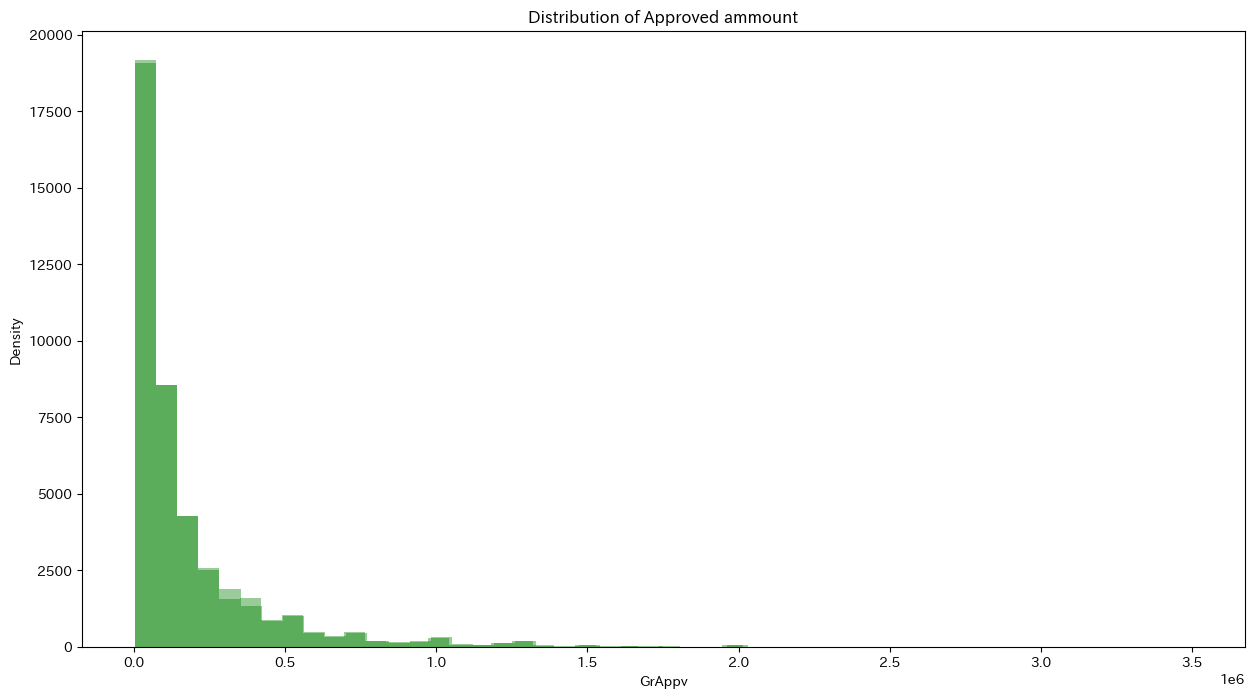

In [63]:
import seaborn as sns
plt.figure(figsize=(15, 8))
sns.distplot(data_dic["train"].GrAppv, color="g", kde=False)
sns.distplot(data_dic["test"].GrAppv, color="g", kde=False)
plt.ylabel('Density')
plt.title('Distribution of Approved ammount')
plt.show()


# PCA

In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import japanize_matplotlib

def edit_PCA(train, y , test, k):
    # PCAインスタンスを作成 
    pca = PCA(n_components=k)

    std_sc = StandardScaler()
    std_sc.fit(train)
    std_train = std_sc.transform(train)
    std_test = std_sc.transform(test)

    # PCAモデルにデータをフィット
    pca.fit(std_train)

    # データを低次元に変換
    train_pca = pca.transform(std_train)
    test_pca = pca.transform(std_test)

    evr=pca.explained_variance_ratio_ #寄与率
    cev=np.cumsum(evr) #累積寄与率

    # 寄与率のプロット
    plt.bar(range(1, len(evr) + 1), evr, alpha=0.5, align='center', label='寄与率')
    # 累積寄与率のプロット
    plt.step(range(1, len(cev) + 1), cev, where='mid', label='累積寄与率')

    plt.xlabel("主成分")
    plt.ylabel("寄与率")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    color = ["blue","red"]
    for i in range(2):
        tmp = train_pca[train_y==i]
        plt.scatter(tmp[:,0],tmp[:,1],color=color[i])
        
    return train_pca, test_pca

# Model

## Optuna

In [65]:
def param_write(filename, params):
    f = open(filename, 'w')
    json.dump(params, f)
def param_load(filename):
    f = open(filename, 'r')
    json_dict = json.load(f)
    return json_dict

In [66]:
if TURNING:
    X = data_dic["train"][numerical_columns].drop([CFG["Target"]],axis=1).drop(drop_list,axis=1)
    y = data_dic["train"][numerical_columns][CFG["Target"]]

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: co.objective_lgb(trial, X, y), n_trials=1000)
    #study.optimize(objective(trial, X, y), n_trials=100)

    #スコアを見る
    #print(study.best_params)    
    #print(study.best_value)
    params = study.best_params
    params.update(boosting_type = 'gbdt',
                objective= 'binary',
                metric = 'auc',
                learning_rate =  0.1,
                n_estimators =  500,
                early_stopping_round =  300,
                verbosity = -1,
                random_state =  42)
    param_write("lightGBM.json", params)

    ##---------------------xgboost
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: co.objective_xgb(trial, X, y), n_trials=1000)
    #study.optimize(objective(trial, X, y), n_trials=100)

    #スコアを見る
    print(study.best_params)    
    print(study.best_value)

    params = study.best_params
    params.update(objective='binary:logistic')
    param_write("XGBoost.json", params)

    ##---------------------catboost
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: co.objective_cat(trial, X, y), n_trials=1000)
    #study.optimize(objective(trial, X, y), n_trials=100)

    #スコアを見る
    print(study.best_params)    
    print(study.best_value)

    params = study.best_params
    params.update(iterations=10000,
                 random_seed=42)
    param_write("Catboost.json", params)

# Train

In [67]:


def lgb_train(X_train, X_val, y_train, y_val):
    # データセットを生成する
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
    lgb_train = lgb.Dataset(X_train, y_train) 
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train) 

    callbacks = [ 
            lgb.log_evaluation(500), 
            lgb.early_stopping(300), 
        ]

    params = param_load("param/lightGBM.json")
    
    gbm = lgb.train(params, 
                lgb_train, 
                num_boost_round=10000, 
                valid_sets=lgb_eval,
                #feval=custom_metrics,
                #eval_metric=lgb_metric,
                callbacks=callbacks,)

    return gbm


In [68]:


def xgb_train(X_train, X_valid, y_train, y_valid):
    param = param_load("param/XGBoost.json")
   
    model = XGBClassifier(random_state=42, 
                             tree_method='gpu_hist', 
                             gpu_id=0, 
                             predictor="gpu_predictor",
                             early_stopping_rounds=150,
                             **param )
    
    model.fit(X_train,
              y_train,
              eval_set=[(X_valid,y_valid)],
              verbose=False)

    return model


In [69]:

def cat_train(X_train, X_valid, y_train, y_valid):
    param = param_load("param/Catboost.json")
    
    train_pool = Pool(X_train, y_train)
    valid_pool = Pool(X_valid, y_valid)
    model = CatBoostClassifier(**param,
                              #task_type= 'GPU',
                              silent=True)
    model.fit(train_pool,
             eval_set=valid_pool,# 検証用データ
             early_stopping_rounds=100, # 10回以上精度が改善しなければ中止
             use_best_model=True,# 最も精度が高かったモデルを使用するかの設定
             )
    

    return model


In [70]:

def Tabpfn_train(X_train, X_val, y_train, y_val):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    classifier = TabPFNClassifier(device = device , N_ensemble_configurations=3)
    classifier.fit(X_train, y_train, overwrite_warning =True)
    
    return classifier
def Tabpfn_pred(model, data):
    # 予測結果
    y_eval, p_eval = model.predict(data, return_winning_probability=True)
    
    # TabPFNの確率
    #proba_val = model.predict_proba(X_val)
    proba = model.predict_proba(data)
    return proba

In [71]:

#オーバーサンプリング
ros = ADASYN(random_state=42)
#必要なものだけを使うようにする
enn = EditedNearestNeighbours()

iht = InstanceHardnessThreshold(
    random_state=0,
    estimator=LogisticRegression(solver='lbfgs', multi_class='auto'))

In [72]:
from sklearn.model_selection import StratifiedKFold
def get_KFold_model(X, y, test, model_name, seed = 42):
    #交差検定数
    N_SPLITS = 5
    #結果を入れるための箱を用意しておく
    oof_valid = np.zeros((X.shape[0]))
    oof_test = np.zeros((test.shape[0]))
    oof_test_skf = np.zeros((N_SPLITS, test.shape[0]))
    
    #比率をたもって交差検定をインスタンス化
    skf = StratifiedKFold(n_splits=N_SPLITS,shuffle=True,random_state = seed)

    for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print('[CV] {}/{}'.format(i+1, N_SPLITS))        
        #学習データと答えを分割
        print(X.shape,y.shape)
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_name == "TabPFN":
            print("--TabPFN--")
            model = Tabpfn_train(X_valid, X_train, y_valid, y_train)
            proba_val = Tabpfn_pred(model, X_train)
            proba_test = Tabpfn_pred(model, test)
            
        elif model_name == "lightGBM":
            print("--lightGBM--")
            model = lgb_train(X_train, X_valid, y_train, y_valid)
            # importanceを表示する
            importance = pd.DataFrame(model.feature_importance(), index=model.feature_name(), columns=['importance'])
            importance.to_csv("importance.csv")

            proba_val = model.predict(X_valid)
            proba_test = model.predict(test)
            
        elif model_name == "XGBoost":
            print("--XGBoost--")
            model = xgb_train(X_train, X_valid, y_train, y_valid)
            proba_val = model.predict_proba(X_valid)[:,1]
            proba_test = model.predict_proba(test)[:,1]
        
        elif model_name == "CatBoost":
            print("--CatBoost--")
            model = cat_train(X_train, X_valid, y_train, y_valid)
            proba_val = model.predict_proba(X_valid)[:,1]
            proba_test = model.predict_proba(test)[:,1]
            
        oof_valid[valid_index] = proba_val#[:, 0]
        oof_test_skf[i, :] = proba_test#[:, 0]
    print(np.array(oof_test_skf).shape)
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    # 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
    fpr, tpr, thresholds = roc_curve(y, oof_valid)
    print("auc",auc(fpr, tpr))
    
    return oof_valid, oof_test

oof_valid = []
oof_test = []
train_X = data_dic["train"][numerical_columns].drop([CFG["Target"]],axis=1).drop(drop_list,axis=1)
train_y = data_dic["train"][CFG["Target"]]
test_X = data_dic["test"][train_X.columns]
if VALID:
    test_y = data_dic["test"][CFG["Target"]]

train_X = train_X.values
train_y = train_y.values
test_X = test_X.values

oof_valid_lgb, oof_test_lgb = get_KFold_model(train_X, train_y, test_X, "lightGBM", 42)
oof_valid_xgb, oof_test_xgb = get_KFold_model(train_X, train_y, test_X, "XGBoost", 42)
oof_valid_cat, oof_test_cat = get_KFold_model(train_X, train_y, test_X, "CatBoost", 42)

oof_valid.append([oof_valid_lgb, oof_valid_xgb,oof_valid_cat])
oof_test.append([oof_test_lgb, oof_test_xgb, oof_test_cat])

[CV] 1/5
(42307, 62) (42307,)
--lightGBM--
(33845, 62) (8462, 62) (33845,) (8462,)
Training until validation scores don't improve for 300 rounds


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


KeyboardInterrupt: 

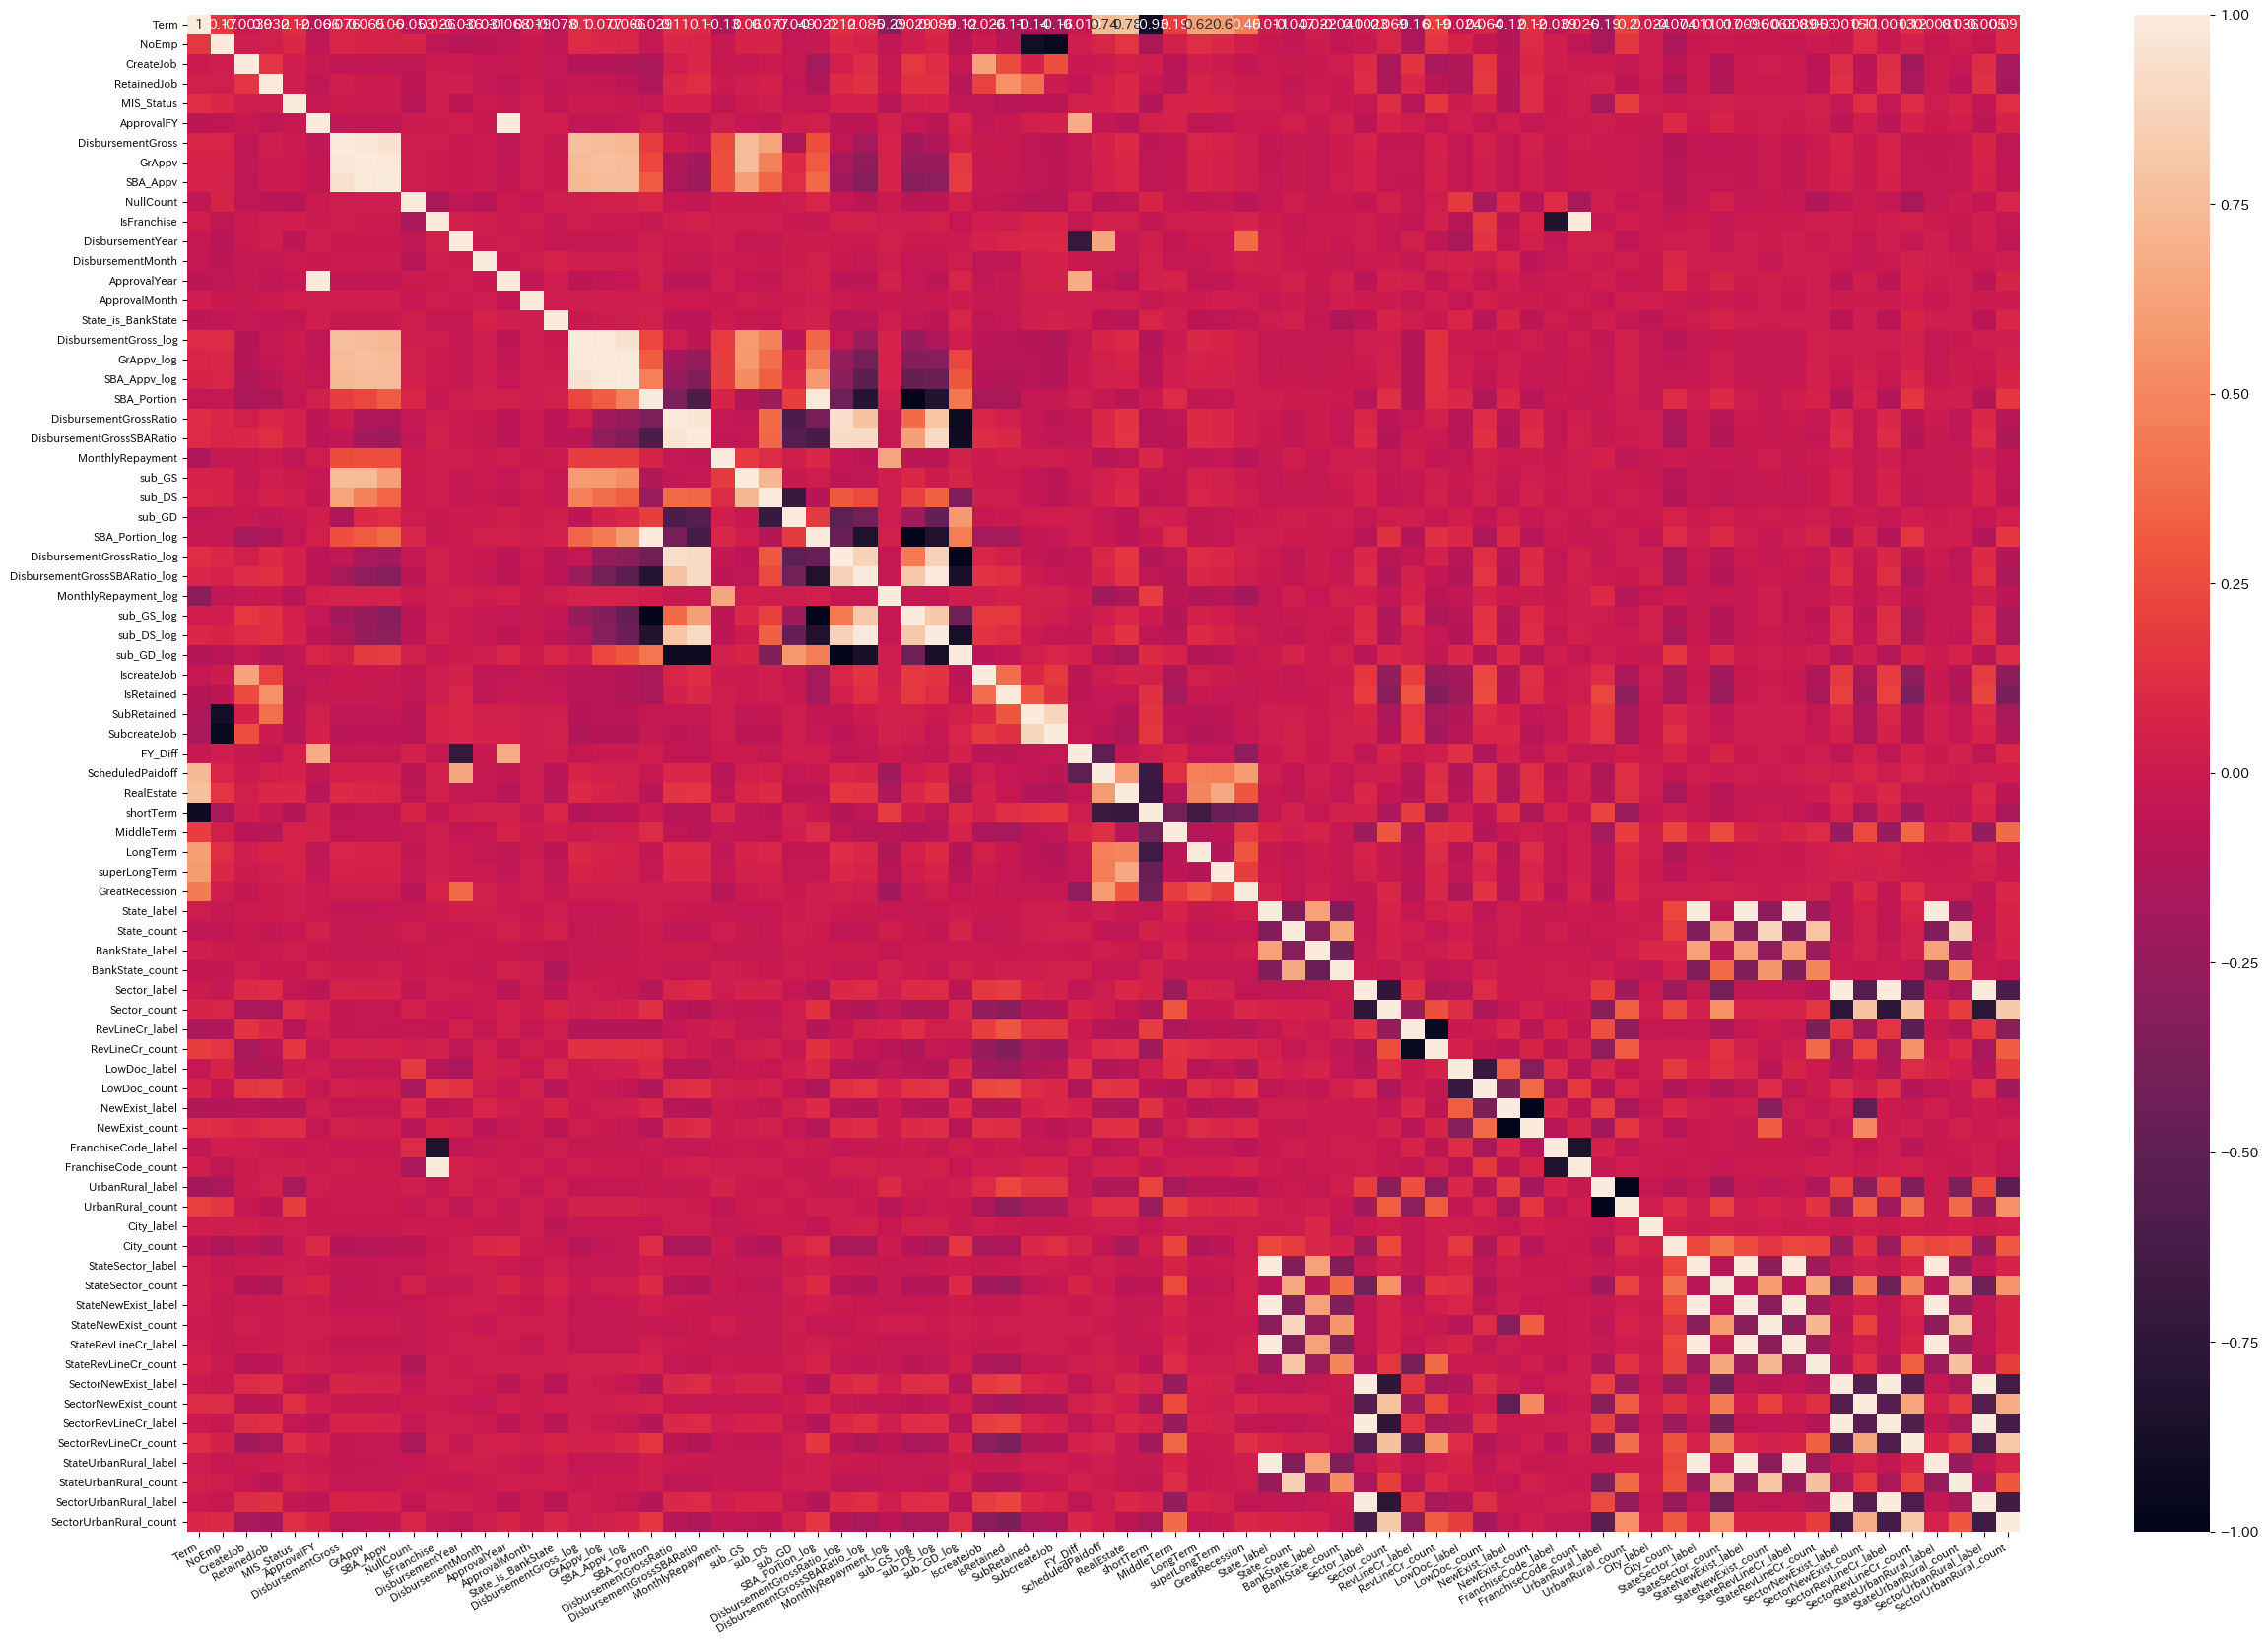

In [47]:
# Correlation Matrix
cor_fig, cor_ax = plt.subplots(figsize=(30, 20))
corr_matrix = data_dic["train"][numerical_columns].corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

In [48]:
imp = pd.read_csv("importance.csv",index_col = "Unnamed: 0")
imp.index = data_dic["train"][numerical_columns].drop([CFG["Target"]],axis=1).drop(drop_list,axis=1).columns
imp

,importance
NoEmp,123
CreateJob,50
ApprovalFY,112
DisbursementGross,43
SBA_Appv,404
...,...
SectorRevLineCr_count,52
StateUrbanRural_label,400
StateUrbanRural_count,187
SectorUrbanRural_label,243


In [49]:
oof_valid = np.mean(oof_valid,axis=1)[0]
oof_test = np.mean(oof_test,axis=1)[0]

# Evaluation

lgb 0.7810304668936322
xgb 0.7809283219191544
cat 0.7792550432987613
mean 0.7847192512074674


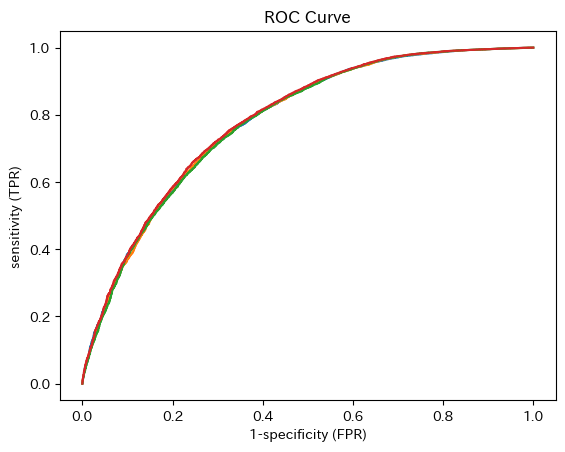

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
fpr, tpr, thresholds = roc_curve(train_y, oof_valid_lgb)
# 描画
plt.plot(fpr,tpr)
plt.xlabel('1-specificity (FPR)') 
plt.ylabel('sensitivity (TPR)')
plt.title('ROC Curve')

print("lgb",auc(fpr, tpr))

# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
fpr, tpr, thresholds = roc_curve(train_y, oof_valid_xgb)
# 描画
plt.plot(fpr,tpr)
plt.xlabel('1-specificity (FPR)') 
plt.ylabel('sensitivity (TPR)')
plt.title('ROC Curve')


print("xgb",auc(fpr, tpr))

# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
fpr, tpr, thresholds = roc_curve(train_y, oof_valid_cat)
# 描画
plt.plot(fpr,tpr)
plt.xlabel('1-specificity (FPR)') 
plt.ylabel('sensitivity (TPR)')
plt.title('ROC Curve')

print("cat",auc(fpr, tpr))

# 陽性の確率だけが必要なので[:, 1]をして陰性の確率を落とす
fpr, tpr, thresholds = roc_curve(train_y, oof_valid)
# 描画
plt.plot(fpr,tpr)
plt.xlabel('1-specificity (FPR)') 
plt.ylabel('sensitivity (TPR)')
plt.title('ROC Curve')

print("mean",auc(fpr, tpr))

plt.show()

if VALID:
    fpr, tpr, thresholds = roc_curve(test_y, oof_test_lgb)
    print("lgb",auc(fpr, tpr))
    fpr, tpr, thresholds = roc_curve(test_y, oof_test_xgb)
    print("xgb",auc(fpr, tpr))
    fpr, tpr, thresholds = roc_curve(test_y, oof_test_cat)
    print("cat",auc(fpr, tpr))
    fpr, tpr, thresholds = roc_curve(test_y, oof_test)
    print("mean",auc(fpr, tpr))

773 0.6771098628033227
733 0.676317248611277
758 0.6777800078421244
755 0.6793101602119258


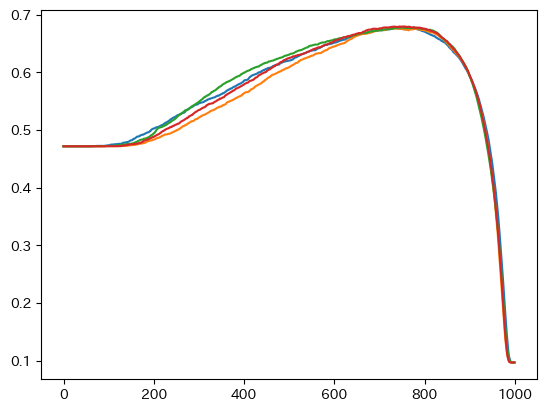

In [51]:
for oof in [oof_valid_lgb, oof_valid_xgb, oof_valid_cat, oof_valid]:
    acc = []
    f1 = []
    for rate in [0.001* i for i in range(1000)]:
        acc.append(accuracy_score(train_y, (oof>rate).astype(int)))
        f1.append(f1_score(train_y, (oof>rate).astype(int), average='macro'))
        
    plt.plot(f1)
    print(np.argmax(f1),np.max(f1))

In [52]:
from sklearn.metrics import f1_score
rate = np.argmax(f1)*0.001

print('Accuracy', accuracy_score(train_y, (oof_valid>rate).astype(int)))
print("F1 score", f1_score(train_y, (oof_valid>rate).astype(int), average='macro'))
if VALID:
    print("--valid--")
    print('Accuracy', accuracy_score(test_y.values, (oof_test>rate).astype(int)))
    print("F1 score", f1_score(test_y.values, (oof_test>rate).astype(int), average='macro'))

Accuracy 0.8913182215708985
F1 score 0.6793101602119258


## submit

In [53]:
if SUBMIT:
    #rate = 0.8
    submit_sample[1] = (oof_test>rate).astype(int)
    dt_now = datetime.now()
    filename = str(dt_now)[:-7].replace(" ","_").replace(":","")
    submit_sample.to_csv(os.path.join(SUBMISSION, filename +"submit.csv"),index=False)

OSError: Cannot save file into a non-existent directory: 'C:\Users\ctiha\Desktop\git upload\submission'

In [ ]:
if SUBMIT:
    import zipfile
    import shutil
    shutil.rmtree('temp/')
    !mkdir temp

    shutil.copy('00_Template.ipynb', 'temp')
    shutil.copy('classifire_optuna.py', 'temp')
    shutil.copy('src/preprocess.py', 'temp')
    shutil.copy('src/model.py', 'temp')
    shutil.copy('lightGBM.json', 'temp')
    shutil.copy('XGBoost.json', 'temp')
    shutil.copy('Catboost.json', 'temp')


    compFile = zipfile.ZipFile(os.path.join(SUBMISSION, filename +"submit.zip"), 'w', zipfile.ZIP_DEFLATED)
    compFile.write('temp/00_Template.ipynb')
    compFile.write('temp/classifire_optuna.py')
    compFile.write('temp/preprocess.py')
    compFile.write('temp/model.py')
    compFile.write('temp/lightGBM.json')
    compFile.write('temp/XGBoost.json')
    compFile.write('temp/Catboost.json')
    compFile.close()